In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)


from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from tools import get_tools_output
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import all_tools
from chat_history import save_chat_history, load_chat_history

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst", "profit_calculator"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "profit_calculator" in last_message.content:
        return "profit_calculator"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    router,
    {
        "profit_calculator":"profit_calculator",
        "data_collector":"data_collector",
        "call_tool": "call_tool", 
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "profit_calculator",
    router,
    {
        "call_tool": "call_tool", 
        "data_collector":"data_collector",
        "analyst":"analyst",
        "reporter":"reporter"
        }
)

workflow.add_conditional_edges(
    "data_collector",
    router,
    {
        "call_tool": "call_tool", 
        "profit_calculator":"profit_calculator",
        "reporter":"reporter",
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    router,
    {
        "__end__": END,
        "data_collector":"data_collector",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()


def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=18
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            # print(e)
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER", "")
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

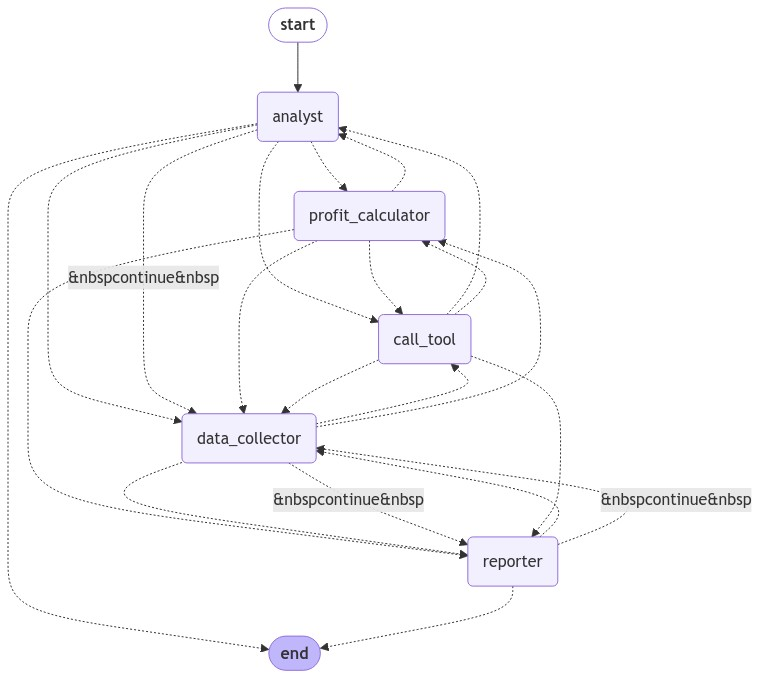

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
# import utils
result = submitUserMessage("วิเคราะห์ร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว", keep_chat_history=True, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_1JWWzSTEKo0Fa3p04YQMF0BO)
 Call ID: call_1JWWzSTEKo0Fa3p04YQMF0BO
  Args:
    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว
  find_place_from_text (call_DH1vbeQgWUha6k55N54RHXEG)
 Call ID: call_DH1vbeQgWUha6k55N54RHXEG
  Args:
    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว
================================= Tool Message =================================
Name: find_place_from_text


    address: 60 127 ซอย ลาดพร้าว 111 แขวงคลองจั่น เขตบางกะปิ กรุงเทพมหานคร 10240 ไทย

    location_name: ลุมพินี เซ็นเตอร์ ลาดพร้าว 111

    
================================== Ai Message ==================================
Name: analyst

I have identified the location and the type of business for your request. 

- **Location**: ลุมพินี เซ็นเตอร์ ลาดพร้าว
- **Keyword**: ร้านอาหารไทย (Thai restaurant)

I will now pass this information to the Data Collector for further analysis.
==============

In [4]:
submitUserMessage("ต้องการขายข้าวในราคา 30 บาทโดยที่มีต้นทุนต่อจาน 18 บาท Monthly fixed costs 30000 Initial investment 0", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_4rcseQsi5S8ijVpbLEWbJ0qG)
 Call ID: call_4rcseQsi5S8ijVpbLEWbJ0qG
  Args:
    input_dict: {'base_price': 30, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_7CTkNKTUwGxN8szQrOIjNLaw)
 Call ID: call_7CTkNKTUwGxN8szQrOIjNLaw
  Args:
    input_dict: {'base_price': 18, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_RJw5nc66AN8EDkNQgzrWEMAE)
 Call ID: call_RJw5nc66AN8EDkNQgzrWEMAE
  Args:
    input_dict: {'base_price': 30, 'category': 'Other Snacks'}
  restaurant_sale_projection (call_3Hb3ojAEIHcLhwQgN6oLoMwo)
 Call ID: call_3Hb3ojAEIHcLhwQgN6oLoMwo
  Args:
    input_dict: {'base_price': 18, 'category': 'Other Snacks'}
  restaurant_sale_projection (call_Oom9NvP78Zg19cYMp0cwaj4E)
 Call ID: call_Oom9NvP78Zg19cYMp0cwaj4E
  Args:
    input_dict: {'base_price': 30, 'category': 'Extras'}
  restaurant_sale_projection (call_RhGRr44U74

('\n\nจากการวิเคราะห์ราคาและต้นทุนในการขายข้าวในราคา 30 บาท โดยมีต้นทุนต่อจาน 18 บาท และค่าใช้จ่ายประจำเดือน 30,000 บาท พบข้อมูลดังนี้:\n\n### การคาดการณ์ยอดขายข้าว (ราคา 30 บาท)\n- **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 849 จาน, ยอดขาย 25,467 บาท\n- **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ 2,252 จาน, ยอดขาย 67,563 บาท\n- **สัปดาห์ที่ 52**: จำนวนการสั่งซื้อ 800 จาน, ยอดขาย 24,009 บาท\n\n### การคาดการณ์ยอดขายข้าว (ต้นทุน 18 บาท)\n- **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 849 จาน, ยอดขาย 15,280 บาท\n- **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ 2,252 จาน, ยอดขาย 40,538 บาท\n- **สัปดาห์ที่ 52**: จำนวนการสั่งซื้อ 800 จาน, ยอดขาย 14,405 บาท\n\n### การวิเคราะห์\n- **ราคาขาย**: 30 บาท\n- **ต้นทุนต่อจาน**: 18 บาท\n- **ค่าใช้จ่ายประจำเดือน**: 30,000 บาท\n\n### ข้อเสนอแนะ\n- การตั้งราคา 30 บาทถือว่ามีความสามารถในการแข่งขันในตลาด แต่ต้องพิจารณาถึงจำนวนการสั่งซื้อที่คาดการณ์ไว้เพื่อให้สามารถครอบคลุมค่าใช้จ่ายประจำเดือนและทำกำไรได้\n- ควรมีการวางแผนการตลาดเพื่อดึงดูดลูกค้าและเพิ่มยอดขายให้สูงขึ้น\n\nการตั้งราคาและการคาดกา

In [5]:
submitUserMessage("if i it passible to sell rice 10 bath each.", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_qn5t3weFJAADGjXxHyTRAweU)
 Call ID: call_qn5t3weFJAADGjXxHyTRAweU
  Args:
    input_dict: {'base_price': 10, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_siqGq5hpA8N4NBJAFZKpH3I9)
 Call ID: call_siqGq5hpA8N4NBJAFZKpH3I9
  Args:
    input_dict: {'base_price': 30, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_o0gujcHTFydhmCvmLNJCPLRc)
 Call ID: call_o0gujcHTFydhmCvmLNJCPLRc
  Args:
    input_dict: {'base_price': 18, 'category': 'Rice Bowl'}
================================= Tool Message =================================
Name: restaurant_sale_projection

sale projection of Rice Bowl:
week	number of order	sale(forecast)
1	849	8,489
5	2,252	22,521
52	800	8,003

================================== Ai Message ==================================
Name: analyst

### การวิเคราะห์การขายข้าวในราคา 10 บาท

#### ข้อมูลการคาดการณ์ยอดขา

('\n### รายงานการวิเคราะห์ร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว\n\n#### 1. สรุป\n- **ภาพรวม**: การวิเคราะห์นี้มุ่งเน้นไปที่ร้านอาหารไทยในพื้นที่ลุมพินี เซ็นเตอร์ ลาดพร้าว โดยมีข้อมูลเกี่ยวกับคู่แข่ง ประชากรในพื้นที่ และแนวโน้มการใช้จ่ายของครัวเรือน\n- **ข้อสรุปความเป็นไปได้**: ตลาดร้านอาหารไทยในพื้นที่นี้มีศักยภาพสูง เนื่องจากมีประชากรหนาแน่นและความต้องการอาหารไทยที่เพิ่มขึ้น\n\n#### 2. แนวคิดธุรกิจ\n- **คำอธิบายผลิตภัณฑ์/บริการ**: ร้านอาหารไทยที่ให้บริการอาหารไทยต้นตำรับ\n- **จุดขายที่ไม่เหมือนใคร (USP)**: การใช้วัตถุดิบสดใหม่และสูตรอาหารที่เป็นเอกลักษณ์\n- **ความต้องการของลูกค้า**: ลูกค้าต้องการอาหารไทยที่มีคุณภาพและรสชาติที่แท้จริง\n\n#### 3. การวิเคราะห์การแข่งขัน\n- **ภูมิทัศน์การแข่งขัน**: มีร้านอาหารไทยหลายแห่งในพื้นที่ เช่น Baan Ice (คะแนน 5.0), Thai Thai Boat Noodles (คะแนน 4.6) และ Khao Man Gai (คะแนน 4.7)\n- **รายการเปรียบเทียบคู่แข่ง**:\n  - AroiChoei Kaprao Tad - LadPrao 101: ราคา 200-300 บาท, คะแนน 3.9\n  - Baan Ice: ราคา 400-500 บาท, คะแนน 5.0\n  - Thai Thai Boat Noo